In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("./multiscale-ssh")))  # replace with real path

from DL_models import UNet  
from DL_models import CNN
from loss_function import CombinedLoss
from train_test import train_model, train_model_r2
from train_test import evaluate_model_sr
from visualization import plot_predictions_vs_targets
from visualization import plot_mean_power_spectrum
from visualization import plot_train_val_losses
from visualization import plot_mean_esr
from dataloading import prepare_dataloaders
from qualitative_eval import mse, r2_score, pearson_corr

In [2]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

# importlib.reload(preprocessing)
# from preprocessing import preprocess_data

# from model_eval_plotting import evaluate_model
# from model_eval_plotting import plot_predictions_vs_targets

# from CNN_setup import SimpleCNN
# from CNN_setup import TensorDataset

# from gcm_filtering import filter_inputs_dataset
# from gcm_filtering import filter_inputs

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset

/srv/conda/envs/notebook/lib/python3.12/site-packages/pop_tools/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


# Helper Functions

In [3]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

# Data Preprocessing

In [4]:
ds_HR_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_HR_globalRegions.zarr", engine="zarr", chunks={}) 
ds_LR_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_LR_globalRegions.zarr", engine="zarr", chunks={}) 
ds_HF_reg = xr.open_dataset("gs://leap-persistent/panalluri/ds_HF_globalRegions.zarr", engine="zarr", chunks={}) 

# u_rel Testing

In [5]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='u_relative', batch_size=32, normalization_type='standardization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [6]:
# Set the values you want
in_channels = 1  # num of input channels
image_height = LR_test.shape[1]
image_width = LR_test.shape[2]
output_channels = 1 

# Instantiate the model with the parameters
model = CNN(in_channels, image_height, image_width, output_channels)
model

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=20736, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=22500, bias=True)
)

In [11]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_urel_stand_global.pth', 
            n_epochs=2000, delta=1e-3, patience=10) # n_epochs=2000) # model_CNN_urel_norm

Trainable Parameters: 5580132
Epoch 1, Train Loss: 7.941e-02, Val Loss: 4.100e-02, Val R²: 0.9583, Epoch Time: 52.32s
Model saved at epoch 1
Epoch 2, Train Loss: 3.042e-02, Val Loss: 2.625e-02, Val R²: 0.9734, Epoch Time: 49.58s
Model saved at epoch 2
Epoch 3, Train Loss: 2.456e-02, Val Loss: 2.093e-02, Val R²: 0.9788, Epoch Time: 46.89s
Model saved at epoch 3
Epoch 4, Train Loss: 1.862e-02, Val Loss: 1.824e-02, Val R²: 0.9815, Epoch Time: 48.70s
Model saved at epoch 4
Epoch 5, Train Loss: 1.622e-02, Val Loss: 1.490e-02, Val R²: 0.9849, Epoch Time: 47.47s
Model saved at epoch 5
Epoch 6, Train Loss: 1.505e-02, Val Loss: 1.491e-02, Val R²: 0.9849, Epoch Time: 50.16s
Model saved at epoch 6
Epoch 7, Train Loss: 1.379e-02, Val Loss: 1.256e-02, Val R²: 0.9872, Epoch Time: 47.67s
Model saved at epoch 7
Epoch 8, Train Loss: 1.231e-02, Val Loss: 1.126e-02, Val R²: 0.9886, Epoch Time: 49.03s
Model saved at epoch 8
Epoch 9, Train Loss: 1.096e-02, Val Loss: 1.067e-02, Val R²: 0.9892, Epoch Time: 4

In [7]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_urel_stand_global.pth') # model_CNN_urel_norm
sr_pred

Loaded model parameters from ./model_CNN_urel_stand_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[-1.1148391 , -1.0992044 , -1.084784  , ..., -0.09415005,
         -0.06109288, -0.06103552],
        [-1.1024365 , -1.0695817 , -1.0861772 , ..., -0.045824  ,
         -0.07745104, -0.06903464],
        [-1.073298  , -1.0648791 , -1.0823094 , ..., -0.04457474,
         -0.05239368, -0.05741289],
        ...,
        [ 1.4837362 ,  1.5297347 ,  1.5238385 , ...,  0.16800159,
          0.16927043,  0.14635904],
        [ 1.5239377 ,  1.5538071 ,  1.5199946 , ...,  0.16889322,
          0.16452874,  0.1708265 ],
        [ 1.5246742 ,  1.5533674 ,  1.5352037 , ...,  0.17848432,
          0.15538101,  0.17123991]],

       [[ 0.19652754,  0.21848923,  0.22207251, ...,  0.90040445,
          0.91148037,  0.8820832 ],
        [ 0.2064304 ,  0.2214974 ,  0.23718444, ...,  0.91012025,
          0.9072533 ,  0.897342  ],
        [ 0.20422018,  0.22724175,  0.24496326, ...,  0.91889846,
          0.9178004 ,  0.9150798 ],
...
          0.05440101,  0.04559064],
        [ 0.59464777,  0.61993504,  0.5659861 , ...,  0.0689049 ,
          0.07832628,  0.08319781],
        [ 0.5897894 ,  0.62467617,  0.59293526, ...,  0.09966699,
          0.06307553,  0.09162186]],

       [[-0.68698895, -0.67444545, -0.6665493 , ..., -0.8701196 ,
         -0.8365984 , -0.8290197 ],
        [-0.69944865, -0.69091886, -0.6965597 , ..., -0.8520126 ,
         -0.8581164 , -0.85043156],
        [-0.700221  , -0.693814  , -0.7204939 , ..., -0.8745184 ,
         -0.8787234 , -0.8782719 ],
        ...,
        [-1.4020332 , -1.3773541 , -1.3862758 , ..., -1.3476859 ,
         -1.3398569 , -1.3472747 ],
        [-1.3829614 , -1.3681817 , -1.3914522 , ..., -1.3284155 ,
         -1.3385386 , -1.3327048 ],
        [-1.3997009 , -1.3774357 , -1.4056736 , ..., -1.3277284 ,
         -1.3424613 , -1.3191944 ]]],
      shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 3310 3605 7690 1396 4517 ... 5313 6457 2042 8647
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [8]:
r2_scores_urel = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_urel)
best_r2 = r2_scores_urel[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9986 at index 1197


In [9]:
mean, std = norm_stats
urel_HR_test = HR_test * std + mean
urel_LR_test = LR_test * std + mean
urel_sr_pred = sr_pred * std + mean

# v_rel Testing

In [10]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='v_relative', batch_size=32, normalization_type='standardization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [ ]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_vrel_stand_global.pth', 
            n_epochs=2000, delta=1e-3, patience=10) # n_epochs=2000) 

Trainable Parameters: 5580132
Epoch 1, Train Loss: 1.144e-02, Val Loss: 1.033e-02, Val R²: 0.9901, Epoch Time: 48.35s
Model saved at epoch 1
Epoch 2, Train Loss: 9.594e-03, Val Loss: 9.865e-03, Val R²: 0.9906, Epoch Time: 47.40s
Model saved at epoch 2
Epoch 3, Train Loss: 9.437e-03, Val Loss: 9.732e-03, Val R²: 0.9907, Epoch Time: 47.18s
Model saved at epoch 3
Epoch 4, Train Loss: 8.998e-03, Val Loss: 9.240e-03, Val R²: 0.9912, Epoch Time: 47.17s
Model saved at epoch 4
Epoch 5, Train Loss: 9.044e-03, Val Loss: 8.447e-03, Val R²: 0.9919, Epoch Time: 48.39s
Model saved at epoch 5
Epoch 6, Train Loss: 8.743e-03, Val Loss: 8.466e-03, Val R²: 0.9919, Epoch Time: 47.98s
Model saved at epoch 6
Epoch 7, Train Loss: 8.320e-03, Val Loss: 8.388e-03, Val R²: 0.9920, Epoch Time: 48.80s
Model saved at epoch 7
Epoch 8, Train Loss: 8.071e-03, Val Loss: 8.394e-03, Val R²: 0.9920, Epoch Time: 48.26s
Model saved at epoch 8
Epoch 9, Train Loss: 7.972e-03, Val Loss: 8.594e-03, Val R²: 0.9918, Epoch Time: 4

In [11]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_vrel_stand_global.pth')
sr_pred

Loaded model parameters from ./model_CNN_vrel_stand_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[ 5.0157934e-02,  3.0961744e-02,  2.6781749e-02, ...,
         -1.5799195e+00, -1.5813115e+00, -1.5766374e+00],
        [ 3.7135206e-02,  2.5655728e-02, -2.3052692e-03, ...,
         -1.5867550e+00, -1.5887539e+00, -1.5960908e+00],
        [ 4.4452365e-02,  3.1537022e-02,  5.4386407e-03, ...,
         -1.5891485e+00, -1.5885098e+00, -1.5863259e+00],
        ...,
        [ 2.4507712e-01,  2.4373522e-01,  2.6340348e-01, ...,
         -2.5049179e+00, -2.5045886e+00, -2.4881775e+00],
        [ 2.5807941e-01,  2.3624933e-01,  2.4404180e-01, ...,
         -2.4957497e+00, -2.4800065e+00, -2.4809055e+00],
        [ 2.4229337e-01,  2.3402609e-01,  2.6091450e-01, ...,
         -2.4830160e+00, -2.4601114e+00, -2.4548633e+00]],

       [[-2.7679378e-02, -1.7503705e-02, -1.5559394e-02, ...,
          7.4005246e-01,  7.6656055e-01,  7.3284227e-01],
        [-2.7886389e-02, -4.0263116e-02, -3.0667681e-02, ...,
          7.3454171e-01,  7.4480182e-01,  7.3663932e-01],
        [-1.4961518e-02, -1.9854195e-02, -1.4978146e-02, ...,
          7.3725247e-01,  7.4599946e-01,  7.4728525e-01],
...
         -6.5141505e-01, -6.4773256e-01, -6.6681612e-01],
        [-1.1828560e+00, -1.1869951e+00, -1.1969352e+00, ...,
         -6.5256256e-01, -6.3849044e-01, -6.7609292e-01],
        [-1.2280775e+00, -1.2123910e+00, -1.1724657e+00, ...,
         -6.7324579e-01, -6.7866367e-01, -6.6086739e-01]],

       [[ 8.9626706e-01,  8.9005399e-01,  8.8737917e-01, ...,
          1.2332027e+00,  1.2254387e+00,  1.2642431e+00],
        [ 9.0002465e-01,  9.1162354e-01,  9.0184039e-01, ...,
          1.2493908e+00,  1.2459528e+00,  1.2653553e+00],
        [ 9.2126822e-01,  9.1578484e-01,  8.9759684e-01, ...,
          1.2443681e+00,  1.2461412e+00,  1.2641366e+00],
        ...,
        [-6.3032347e-01, -6.2824589e-01, -6.1325157e-01, ...,
          3.1865460e-01,  3.3329809e-01,  3.6652064e-01],
        [-6.3112229e-01, -6.2883520e-01, -6.2372231e-01, ...,
          2.8772685e-01,  3.2304266e-01,  3.4601533e-01],
        [-6.2549973e-01, -6.3655454e-01, -6.2810409e-01, ...,
          2.6991114e-01,  2.9791564e-01,  3.2537061e-01]]],
      shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 3128 8160 157 7035 6199 ... 3111 4937 1933 2064
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [12]:
r2_scores_vrel = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_vrel)
best_r2 = r2_scores_vrel[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9988 at index 822


In [13]:
mean, std = norm_stats
vrel_HR_test = HR_test * std + mean
vrel_LR_test = LR_test * std + mean
vrel_sr_pred = sr_pred * std + mean

# t_ref Testing

In [14]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='t_ref', batch_size=32, normalization_type='standardization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [15]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_tref_stand_global.pth', 
            n_epochs=2000, delta=1e-3, patience=10) # n_epochs=2000) 

Trainable Parameters: 5580132
Epoch 1, Train Loss: 1.276e-03, Val Loss: 3.924e-04, Val R²: 0.9996, Epoch Time: 49.00s
Model saved at epoch 1
Epoch 2, Train Loss: 4.424e-04, Val Loss: 3.937e-04, Val R²: 0.9996, Epoch Time: 45.97s
Model saved at epoch 2
Epoch 3, Train Loss: 4.636e-04, Val Loss: 5.074e-04, Val R²: 0.9995, Epoch Time: 46.64s
Model saved at epoch 3
Epoch 4, Train Loss: 4.581e-04, Val Loss: 5.155e-04, Val R²: 0.9994, Epoch Time: 45.99s
Model saved at epoch 4
Epoch 5, Train Loss: 4.451e-04, Val Loss: 4.143e-04, Val R²: 0.9995, Epoch Time: 46.27s
Model saved at epoch 5
Epoch 6, Train Loss: 2.037e-03, Val Loss: 5.796e-04, Val R²: 0.9994, Epoch Time: 47.05s
Model saved at epoch 6
Epoch 7, Train Loss: 5.493e-04, Val Loss: 5.109e-04, Val R²: 0.9994, Epoch Time: 46.70s
Model saved at epoch 7
Epoch 8, Train Loss: 4.974e-04, Val Loss: 5.175e-04, Val R²: 0.9994, Epoch Time: 47.42s
Model saved at epoch 8
Epoch 9, Train Loss: 4.827e-04, Val Loss: 4.826e-04, Val R²: 0.9995, Epoch Time: 4

In [15]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_tref_stand_global.pth')
sr_pred

Loaded model parameters from ./model_CNN_tref_stand_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[ 6.7966092e-01,  6.7823082e-01,  6.7721021e-01, ...,
          4.0562999e-01,  4.0409991e-01,  3.9849526e-01],
        [ 6.8005478e-01,  6.7877442e-01,  6.7801261e-01, ...,
          3.9704689e-01,  3.9825073e-01,  3.9228633e-01],
        [ 6.8561143e-01,  6.8172121e-01,  6.7907971e-01, ...,
          3.9442131e-01,  3.8864911e-01,  3.8532418e-01],
        ...,
        [-1.9701177e-01, -1.9421840e-01, -1.9111812e-01, ...,
         -1.9216377e-01, -2.0746960e-01, -2.2633351e-01],
        [-1.9918412e-01, -1.9606628e-01, -1.9587418e-01, ...,
         -1.9331723e-01, -2.1116304e-01, -2.3077384e-01],
        [-2.0523556e-01, -2.0040323e-01, -1.9600224e-01, ...,
         -1.9722688e-01, -2.1626192e-01, -2.3352867e-01]],

       [[ 1.3400979e+00,  1.3395308e+00,  1.3408988e+00, ...,
          1.3755242e+00,  1.3749634e+00,  1.3753961e+00],
        [ 1.3373847e+00,  1.3396724e+00,  1.3373917e+00, ...,
          1.3758492e+00,  1.3741463e+00,  1.3743062e+00],
        [ 1.3417277e+00,  1.3406268e+00,  1.3388690e+00, ...,
          1.3747162e+00,  1.3731166e+00,  1.3747033e+00],
...
          9.8136544e-01,  9.7883105e-01,  9.7830617e-01],
        [ 9.5225877e-01,  9.5349491e-01,  9.5571911e-01, ...,
          9.8418295e-01,  9.8317581e-01,  9.8154330e-01],
        [ 9.5882595e-01,  9.5781064e-01,  9.5888740e-01, ...,
          9.8936486e-01,  9.8903483e-01,  9.8592049e-01]],

       [[ 1.0376062e+00,  1.0370607e+00,  1.0353733e+00, ...,
          1.0446439e+00,  1.0441068e+00,  1.0451975e+00],
        [ 1.0359567e+00,  1.0349742e+00,  1.0350789e+00, ...,
          1.0376626e+00,  1.0393372e+00,  1.0393091e+00],
        [ 1.0321273e+00,  1.0319257e+00,  1.0303080e+00, ...,
          1.0322623e+00,  1.0323709e+00,  1.0325071e+00],
        ...,
        [ 5.2752602e-01,  5.3087234e-01,  5.3304869e-01, ...,
          4.6491298e-01,  4.6315312e-01,  4.6087211e-01],
        [ 5.1855350e-01,  5.2226579e-01,  5.2544272e-01, ...,
          4.5944726e-01,  4.5745468e-01,  4.5392296e-01],
        [ 5.1131082e-01,  5.1279378e-01,  5.1595372e-01, ...,
          4.5231238e-01,  4.5079261e-01,  4.4760090e-01]]],
      shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 3560 7441 8552 4314 1110 ... 1747 4332 8648 5185
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [16]:
r2_scores_tref = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_tref)
best_r2 = r2_scores_tref[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9993 at index 555


In [17]:
mean, std = norm_stats
tref_HR_test = HR_test * std + mean
tref_LR_test = LR_test * std + mean
tref_sr_pred = sr_pred * std + mean

# q_ref Testing

In [18]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='q_ref', batch_size=32, normalization_type='standardization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [20]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_qref_stand_global.pth', 
            n_epochs=2000, delta=1e-3, patience=10) # n_epochs=2000) 

Trainable Parameters: 5580132
Epoch 1, Train Loss: 2.303e-03, Val Loss: 1.590e-03, Val R²: 0.9984, Epoch Time: 48.34s
Model saved at epoch 1
Epoch 2, Train Loss: 1.700e-03, Val Loss: 1.785e-03, Val R²: 0.9982, Epoch Time: 48.24s
Model saved at epoch 2
Epoch 3, Train Loss: 1.642e-03, Val Loss: 1.573e-03, Val R²: 0.9984, Epoch Time: 49.10s
Model saved at epoch 3
Epoch 4, Train Loss: 1.843e-03, Val Loss: 1.776e-03, Val R²: 0.9982, Epoch Time: 47.57s
Model saved at epoch 4
Epoch 5, Train Loss: 1.672e-03, Val Loss: 1.505e-03, Val R²: 0.9985, Epoch Time: 47.92s
Model saved at epoch 5
Epoch 6, Train Loss: 1.538e-03, Val Loss: 1.437e-03, Val R²: 0.9985, Epoch Time: 49.21s
Model saved at epoch 6
Epoch 7, Train Loss: 1.649e-03, Val Loss: 2.499e-03, Val R²: 0.9974, Epoch Time: 49.43s
Model saved at epoch 7
Epoch 8, Train Loss: 1.635e-03, Val Loss: 1.444e-03, Val R²: 0.9985, Epoch Time: 48.13s
Model saved at epoch 8
Epoch 9, Train Loss: 1.619e-03, Val Loss: 4.675e-03, Val R²: 0.9952, Epoch Time: 4

In [19]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_qref_stand_global.pth')
sr_pred

Loaded model parameters from ./model_CNN_qref_stand_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[-0.964573  , -0.965771  , -0.9658012 , ..., -0.9389589 ,
         -0.9383855 , -0.93713486],
        [-0.961442  , -0.9624906 , -0.96424985, ..., -0.9372043 ,
         -0.93580747, -0.93692446],
        [-0.96051383, -0.96048737, -0.9622325 , ..., -0.93522394,
         -0.9369894 , -0.9357883 ],
        ...,
        [-0.64671844, -0.6472542 , -0.6489028 , ..., -0.5473165 ,
         -0.5472114 , -0.54829353],
        [-0.64322376, -0.64564925, -0.64741504, ..., -0.54128534,
         -0.5400693 , -0.54215723],
        [-0.6415418 , -0.6443975 , -0.64435893, ..., -0.5368996 ,
         -0.53557795, -0.5369181 ]],

       [[ 1.1256821 ,  1.1311381 ,  1.1332777 , ...,  1.2476896 ,
          1.2384773 ,  1.227078  ],
        [ 1.1240581 ,  1.1360159 ,  1.1429882 , ...,  1.2475734 ,
          1.2388128 ,  1.2398139 ],
        [ 1.1392913 ,  1.1382754 ,  1.1470834 , ...,  1.2429385 ,
          1.251988  ,  1.2345189 ],
...
          0.01789074,  0.01504585],
        [ 0.33460367,  0.33310595,  0.32678318, ...,  0.01488081,
          0.00952303,  0.00843848],
        [ 0.33747393,  0.33745807,  0.3297173 , ...,  0.01476815,
          0.01251583,  0.00963572]],

       [[ 1.0307502 ,  1.0238178 ,  1.0191488 , ...,  1.116157  ,
          1.1022959 ,  1.0992329 ],
        [ 1.0219618 ,  1.0263808 ,  1.0248642 , ...,  1.1202163 ,
          1.1126755 ,  1.1096371 ],
        [ 1.0382023 ,  1.0305214 ,  1.0223343 , ...,  1.1223593 ,
          1.1135869 ,  1.1078476 ],
        ...,
        [ 0.26912573,  0.26619038,  0.26417032, ...,  0.4396361 ,
          0.4390059 ,  0.45070943],
        [ 0.25995526,  0.25885683,  0.2591429 , ...,  0.42560363,
          0.43233976,  0.4370802 ],
        [ 0.25227958,  0.24629396,  0.24848266, ...,  0.42308164,
          0.42176715,  0.43552488]]],
      shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 5864 7894 3809 8047 4262 ... 3978 3246 1416 7661
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [20]:
r2_scores_qref = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_qref)
best_r2 = r2_scores_qref[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9988 at index 1000


In [21]:
mean, std = norm_stats
qref_HR_test = HR_test * std + mean
qref_LR_test = LR_test * std + mean
qref_sr_pred = sr_pred * std + mean

# SLP Testing

In [22]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='slp', batch_size=32, normalization_type='standardization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [23]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_slp_stand_global.pth', 
            n_epochs=2000, delta=1e-3, patience=10) # n_epochs=2000) 

Trainable Parameters: 5580132
Resuming from epoch 35 with best r2 values [0.9997527599334717, 0.9997643828392029, 0.9970864653587341, 0.9998283982276917, 0.9998375177383423]
Epoch 36, Train Loss: 1.600e-04, Val Loss: 1.977e-04, Val R²: 0.9998, Epoch Time: 50.31s
Epoch 37, Train Loss: 1.177e-04, Val Loss: 8.815e-05, Val R²: 0.9999, Epoch Time: 49.83s
Patience counter: 1/10
Epoch 38, Train Loss: 1.413e-04, Val Loss: 9.351e-05, Val R²: 0.9999, Epoch Time: 47.54s
Patience counter: 2/10
Epoch 39, Train Loss: 1.217e-04, Val Loss: 1.004e-04, Val R²: 0.9999, Epoch Time: 48.89s
Patience counter: 3/10
Epoch 40, Train Loss: 1.170e-04, Val Loss: 8.830e-05, Val R²: 0.9999, Epoch Time: 49.31s
Patience counter: 4/10
Validation R² >= 0.9999, stopping training.
Model saved at epoch 40 with R²=0.9999
Training complete


In [24]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_slp_stand_global.pth')
sr_pred

Loaded model parameters from ./model_CNN_slp_stand_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[-0.23928104, -0.24127251, -0.24275357, ..., -0.28543854,
         -0.28699598, -0.287617  ],
        [-0.2389035 , -0.24058759, -0.24269259, ..., -0.2853184 ,
         -0.2866722 , -0.28760025],
        [-0.23857918, -0.24018197, -0.24213931, ..., -0.2852664 ,
         -0.2865848 , -0.28759825],
        ...,
        [ 0.4583194 ,  0.45929575,  0.45984048, ...,  0.4614865 ,
          0.4606172 ,  0.46004462],
        [ 0.46489093,  0.4653884 ,  0.4664455 , ...,  0.4676945 ,
          0.46705797,  0.46641922],
        [ 0.47135645,  0.47174934,  0.4729097 , ...,  0.47411302,
          0.47375852,  0.47306126]],

       [[-0.05518777, -0.06036296, -0.06394909, ..., -0.6160963 ,
         -0.6209029 , -0.62379915],
        [-0.04725883, -0.05127779, -0.05534823, ..., -0.60481596,
         -0.6070399 , -0.6120081 ],
        [-0.03703586, -0.04148678, -0.04806696, ..., -0.5900825 ,
         -0.59601974, -0.60033464],
...
         -0.22403172, -0.22932461],
        [ 0.22355126,  0.22247086,  0.22076318, ..., -0.21858731,
         -0.22367656, -0.22873665],
        [ 0.22574057,  0.22445726,  0.22297737, ..., -0.21861872,
         -0.22413968, -0.2288641 ]],

       [[ 0.3238613 ,  0.31870463,  0.31334758, ..., -0.33082485,
         -0.33438003, -0.3384047 ],
        [ 0.3243357 ,  0.31999844,  0.31448454, ..., -0.33353218,
         -0.33934367, -0.34186718],
        [ 0.3254845 ,  0.32045734,  0.31664503, ..., -0.33955953,
         -0.34093192, -0.34526676],
        ...,
        [-0.44724575, -0.45722562, -0.46771967, ..., -1.1745399 ,
         -1.1833056 , -1.1899844 ],
        [-0.45403597, -0.4631193 , -0.47018915, ..., -1.1704153 ,
         -1.1782212 , -1.1841029 ],
        [-0.4577627 , -0.46719813, -0.4771313 , ..., -1.1637646 ,
         -1.1714683 , -1.1781868 ]]],
      shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 5713 4231 1657 1579 5863 ... 1187 7198 7585 4420
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [25]:
r2_scores_slp = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_slp)
best_r2 = r2_scores_slp[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9999 at index 207


In [26]:
mean, std = norm_stats
slp_HR_test = HR_test * std + mean
slp_LR_test = LR_test * std + mean
slp_sr_pred = sr_pred * std + mean

# SST Testing

In [27]:
train_loader, val_loader, test_loader, HR_test, LR_test, norm_stats = prepare_dataloaders(ds_HR_reg, ds_LR_reg, var='surface_temp', batch_size=32, normalization_type='standardization')

Training set size: 6132
Validation set size: 1314
Testing set size: 1314


In [28]:
criterion = nn.MSELoss() # default is alpha=1
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cpu")

train_losses, val_losses, r2_vals = train_model_r2(model, train_loader, val_loader,
            criterion, optimizer, device,
            save_path='./model_CNN_sst_stand_global.pth', 
            n_epochs=2000, delta=1e-3, patience=10) # n_epochs=2000) 

Trainable Parameters: 5580132
Resuming from epoch 21 with best r2 values []
Epoch 22, Train Loss: 3.094e-03, Val Loss: 2.996e-03, Val R²: 0.9966, Epoch Time: 46.04s
Model saved at epoch 22
Epoch 23, Train Loss: 2.785e-03, Val Loss: 2.772e-03, Val R²: 0.9968, Epoch Time: 45.68s
Model saved at epoch 23
Epoch 24, Train Loss: 2.710e-03, Val Loss: 2.715e-03, Val R²: 0.9969, Epoch Time: 45.42s
Model saved at epoch 24
Epoch 25, Train Loss: 2.707e-03, Val Loss: 2.710e-03, Val R²: 0.9969, Epoch Time: 45.37s
Model saved at epoch 25
Epoch 26, Train Loss: 2.875e-03, Val Loss: 2.704e-03, Val R²: 0.9969, Epoch Time: 45.62s
Model saved at epoch 26
Epoch 27, Train Loss: 2.685e-03, Val Loss: 2.715e-03, Val R²: 0.9969, Epoch Time: 45.83s
Model saved at epoch 27
Epoch 28, Train Loss: 2.683e-03, Val Loss: 2.728e-03, Val R²: 0.9969, Epoch Time: 45.10s
Model saved at epoch 28
Epoch 29, Train Loss: 2.708e-03, Val Loss: 2.832e-03, Val R²: 0.9968, Epoch Time: 45.20s
Model saved at epoch 29
Epoch 30, Train Loss

In [29]:
device = torch.device("cpu")
sr_pred = evaluate_model_sr(model, device, test_loader, HR_test, './model_CNN_sst_stand_global.pth')
sr_pred

Loaded model parameters from ./model_CNN_sst_stand_global.pth


<xarray.DataArray (time: 1314, yt_ocean: 150, xt_ocean: 150)> Size: 118MB
array([[[-1.0859356 , -1.0888817 , -1.0915861 , ..., -1.1447237 ,
         -1.1505693 , -1.1491075 ],
        [-1.0862998 , -1.0897741 , -1.0908251 , ..., -1.1446195 ,
         -1.1452767 , -1.1405296 ],
        [-1.0811356 , -1.0875248 , -1.0906495 , ..., -1.1367648 ,
         -1.136791  , -1.1380051 ],
        ...,
        [-0.3957747 , -0.39588642, -0.39330053, ..., -0.35512924,
         -0.3550805 , -0.35498136],
        [-0.39501485, -0.39455864, -0.3920401 , ..., -0.34972888,
         -0.35235298, -0.3510586 ],
        [-0.395548  , -0.39099762, -0.39084536, ..., -0.34471744,
         -0.34529987, -0.34741324]],

       [[ 0.0524498 ,  0.0526851 ,  0.05426693, ..., -0.1563219 ,
         -0.15131423, -0.15107544],
        [ 0.05085964,  0.04780539,  0.04942873, ..., -0.1584347 ,
         -0.15863581, -0.15901867],
        [ 0.04554421,  0.04629344,  0.0476269 , ..., -0.16168237,
         -0.16197892, -0.16144408],
...
          0.43653333,  0.43473405],
        [ 0.4989887 ,  0.49501535,  0.49101976, ...,  0.43144643,
          0.4308395 ,  0.4269427 ],
        [ 0.49501562,  0.48971325,  0.48537698, ...,  0.42848754,
          0.42509988,  0.4216213 ]],

       [[ 0.5036659 ,  0.50463414,  0.5020253 , ...,  0.39563924,
          0.39851868,  0.3958378 ],
        [ 0.50231785,  0.50027806,  0.50184214, ...,  0.3999149 ,
          0.4030176 ,  0.40004307],
        [ 0.49975306,  0.49814352,  0.49898088, ...,  0.4050917 ,
          0.40301993,  0.40869308],
        ...,
        [ 0.9743123 ,  0.96251976,  0.9515705 , ...,  1.0200611 ,
          1.0180328 ,  1.0159603 ],
        [ 0.97744375,  0.9678251 ,  0.95733166, ...,  1.0199423 ,
          1.0243886 ,  1.0157677 ],
        [ 0.97939575,  0.97018206,  0.96745837, ...,  1.0228643 ,
          1.0216652 ,  1.014305  ]]],
      shape=(1314, 150, 150), dtype=float32)
Coordinates:
  * time      (time) int64 11kB 4257 3354 1091 4470 3983 ... 6305 1887 5140 8334
  * yt_ocean  (yt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150
  * xt_ocean  (xt_ocean) int64 1kB 1 2 3 4 5 6 7 ... 144 145 146 147 148 149 150

In [30]:
r2_scores_sst = r2_per_sample(HR_test.values, sr_pred.values)

best_index = np.argmax(r2_scores_sst)
best_r2 = r2_scores_sst[best_index]

print(f"Best R² = {best_r2:.4f} at index {best_index}")

Best R² = 0.9942 at index 1217


In [31]:
mean, std = norm_stats
sst_HR_test = HR_test * std + mean
sst_LR_test = LR_test * std + mean
sst_sr_pred = sr_pred * std + mean

# Figures

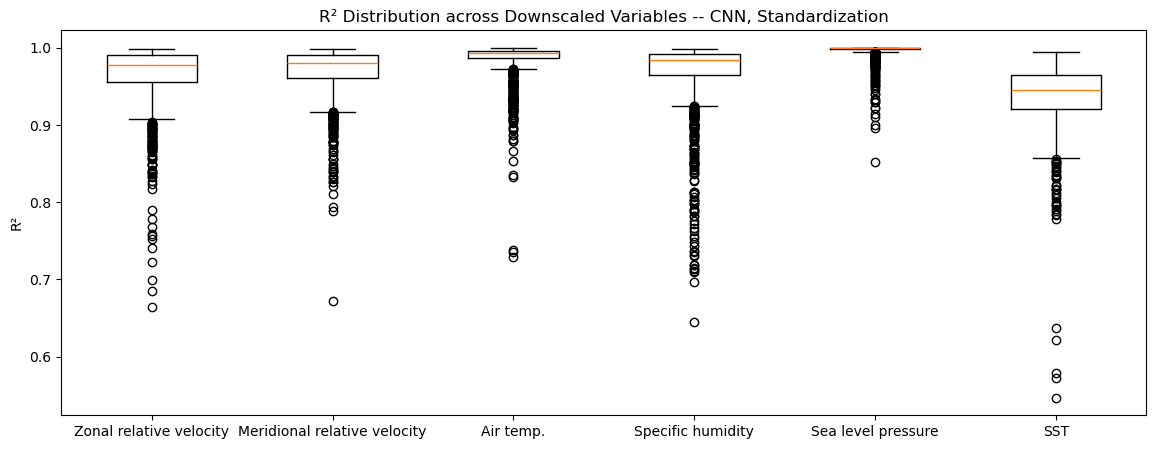

In [32]:
data = [r2_scores_urel, r2_scores_vrel, r2_scores_tref, r2_scores_qref, r2_scores_slp, r2_scores_sst]

plt.figure(figsize=(14, 5))
plt.boxplot(data, vert=True)  # each array becomes a separate boxplot
plt.xticks([1, 2, 3, 4, 5, 6], ["Zonal relative velocity", "Meridional relative velocity", 
                                        "Air temp.", "Specific humidity", "Sea level pressure", "SST"])  # label each box
plt.ylabel("R²")
plt.title("R² Distribution across Downscaled Variables -- CNN, Standardization")
plt.show()

In [33]:
# Suppose you have 6 arrays: a1, a2, ..., a6 (all same length)
arrays = [r2_scores_urel, r2_scores_vrel, r2_scores_tref, r2_scores_qref, r2_scores_slp, r2_scores_sst]

# Stack into shape (6, N) and take mean over axis=0
mean_array = np.mean(np.stack(arrays, axis=0), axis=0)

# Find the max value and its index
max_val = np.max(mean_array)
max_idx = np.argmax(mean_array)

print(f"Max value = {max_val}, at index = {max_idx}")

Max value = 0.9937955538431803, at index = 785


In [34]:
# Find the min value and its index
min_val = np.min(mean_array)
min_idx = np.argmin(mean_array)

print(f"Min value = {min_val}, at index = {min_idx}")

Min value = 0.889789472023646, at index = 63


In [35]:
# Make a Dataset
ds_cnn_stand = xr.Dataset()

# Manually add variables
ds_cnn_stand["u_rel_sr"] = (("time", "y", "x"), urel_sr_pred.values)
ds_cnn_stand["v_rel_sr"] = (("time", "y", "x"), vrel_sr_pred.values)
ds_cnn_stand["t_ref_sr"] = (("time", "y", "x"), tref_sr_pred.values)
ds_cnn_stand["q_ref_sr"] = (("time", "y", "x"), qref_sr_pred.values)
ds_cnn_stand["slp_sr"] = (("time", "y", "x"), slp_sr_pred.values)
ds_cnn_stand["sst_sr"] = (("time", "y", "x"), sst_sr_pred.values)

ds_cnn_stand["u_rel_hr"] = (("time", "y", "x"), urel_HR_test.values)
ds_cnn_stand["v_rel_hr"] = (("time", "y", "x"), vrel_HR_test.values)
ds_cnn_stand["t_ref_hr"] = (("time", "y", "x"), tref_HR_test.values)
ds_cnn_stand["q_ref_hr"] = (("time", "y", "x"), qref_HR_test.values)
ds_cnn_stand["slp_hr"] = (("time", "y", "x"), slp_HR_test.values)
ds_cnn_stand["sst_hr"] = (("time", "y", "x"), sst_HR_test.values)

ds_cnn_stand["u_rel_lr"] = (("time", "y", "x"), urel_LR_test)
ds_cnn_stand["v_rel_lr"] = (("time", "y", "x"), vrel_LR_test)
ds_cnn_stand["t_ref_lr"] = (("time", "y", "x"), tref_LR_test)
ds_cnn_stand["q_ref_lr"] = (("time", "y", "x"), qref_LR_test)
ds_cnn_stand["slp_lr"] = (("time", "y", "x"), slp_LR_test)
ds_cnn_stand["sst_lr"] = (("time", "y", "x"), sst_LR_test)

print(ds_cnn_stand)

<xarray.Dataset> Size: 2GB
Dimensions:   (time: 1314, y: 150, x: 150)
Dimensions without coordinates: time, y, x
Data variables: (12/18)
    u_rel_sr  (time, y, x) float32 118MB -6.361 -6.26 -6.167 ... -7.824 -7.674
    v_rel_sr  (time, y, x) float32 118MB 0.2121 0.1209 0.1011 ... 1.389 1.52
    t_ref_sr  (time, y, x) float32 118MB 294.6 294.6 294.6 ... 292.6 292.6 292.6
    q_ref_sr  (time, y, x) float32 118MB 0.005419 0.005414 ... 0.01213 0.01219
    slp_sr    (time, y, x) float32 118MB 1.009e+05 1.009e+05 ... 9.981e+04
    sst_sr    (time, y, x) float32 118MB 280.5 280.5 280.5 ... 299.4 299.4 299.3
    ...        ...
    u_rel_lr  (time, y, x) float32 118MB -5.713 -5.691 -5.668 ... -8.007 -8.008
    v_rel_lr  (time, y, x) float32 118MB -0.2009 -0.2467 -0.2934 ... 1.724 1.825
    t_ref_lr  (time, y, x) float32 118MB 294.4 294.4 294.4 ... 292.6 292.5 292.5
    q_ref_lr  (time, y, x) float32 118MB 0.005414 0.005414 ... 0.01241 0.01241
    slp_lr    (time, y, x) float32 118MB 1.009e+05 

In [37]:
ds_cnn_stand.to_zarr("gs://leap-persistent/panalluri/cnn_stand_fluxInputs_global.zarr", zarr_version=2)

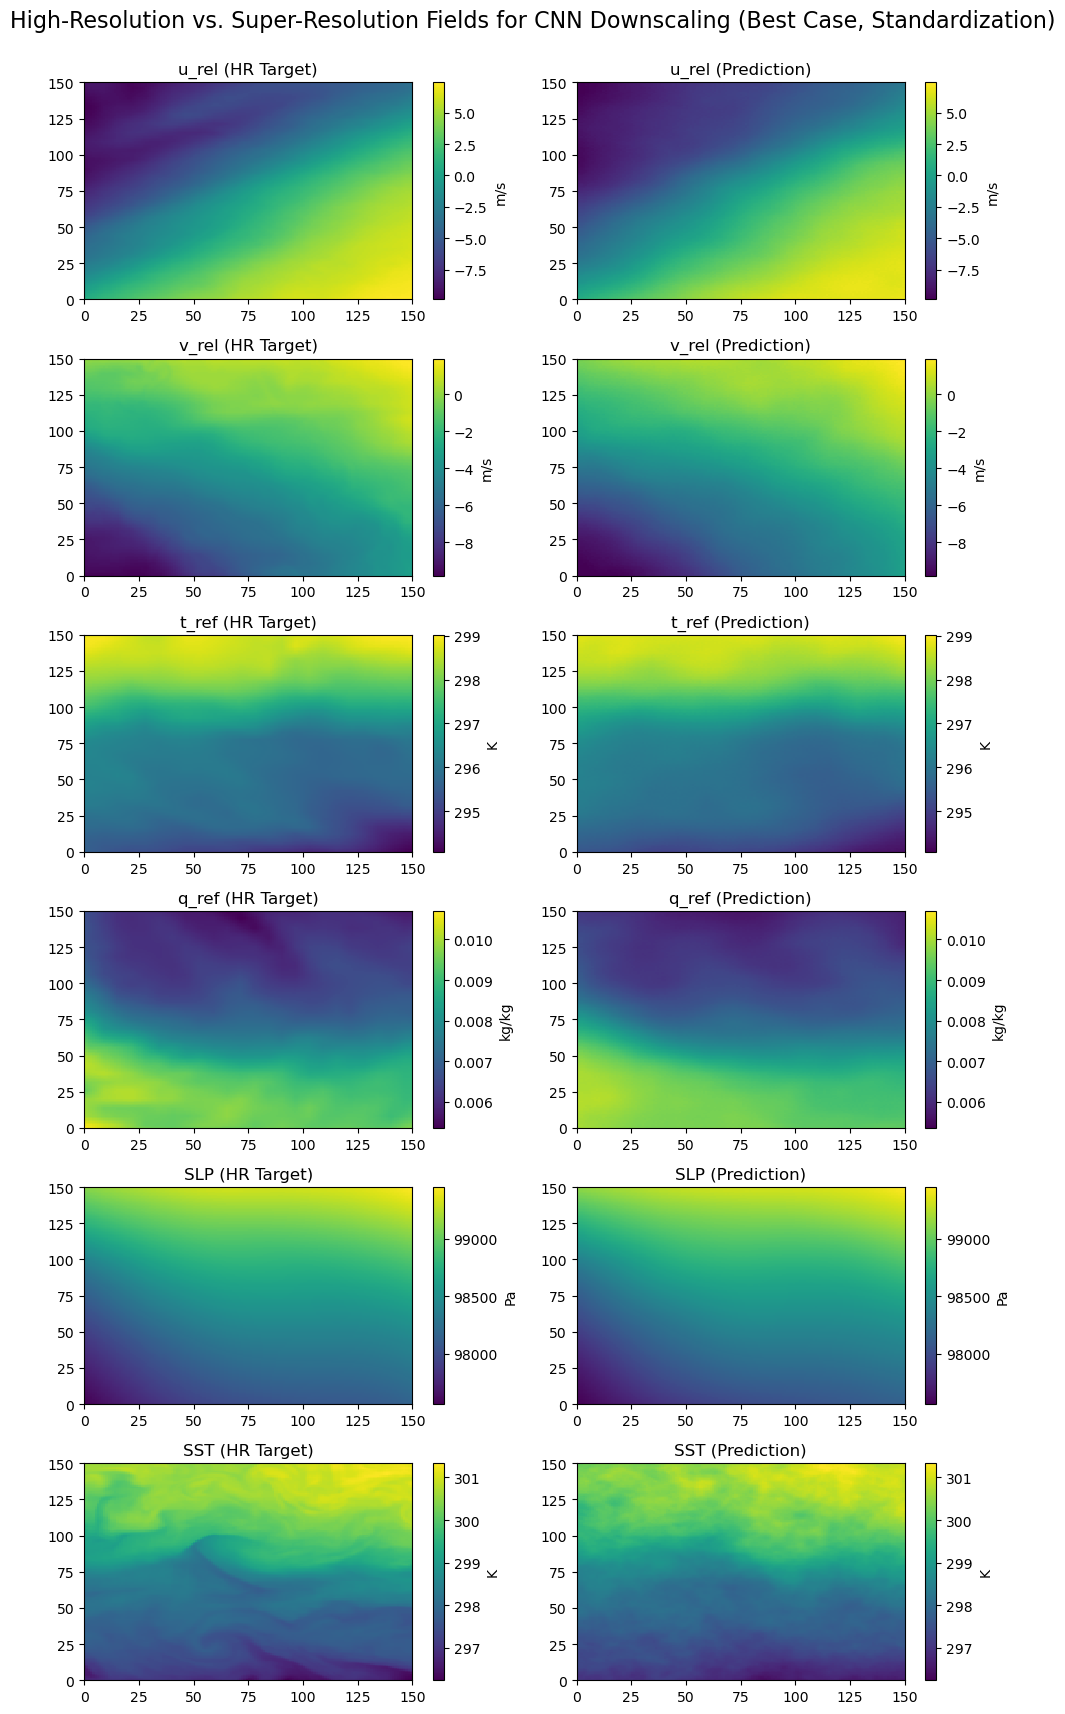

In [38]:
fig, axes = plt.subplots(6, 2, figsize=(10, 18))

vmins = [urel_HR_test[max_idx].min().values, vrel_HR_test[max_idx].min().values, tref_HR_test[max_idx].min().values,
         qref_HR_test[max_idx].min().values, slp_HR_test[max_idx].min().values, sst_HR_test[max_idx].min().values]
vmaxs = [urel_HR_test[max_idx].max().values, vrel_HR_test[max_idx].max().values, tref_HR_test[max_idx].max().values,
         qref_HR_test[max_idx].max().values, slp_HR_test[max_idx].max().values, sst_HR_test[max_idx].max().values]

# Add figure-level title
fig.suptitle("High-Resolution vs. Super-Resolution Fields for CNN Downscaling (Best Case, Standardization)", fontsize=16, y=0.95)

# Top-left
im = axes[0, 0].pcolor(urel_HR_test[max_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 0].set_title("u_rel (HR Target)")
fig.colorbar(im, ax=axes[0, 0], label="m/s")

# Top-right
im = axes[0, 1].pcolor(urel_sr_pred[max_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 1].set_title("u_rel (Prediction)")
fig.colorbar(im, ax=axes[0, 1], label="m/s")

# Second row
im = axes[1, 0].pcolor(vrel_HR_test[max_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 0].set_title("v_rel (HR Target)")
fig.colorbar(im, ax=axes[1, 0], label="m/s")

im = axes[1, 1].pcolor(vrel_sr_pred[max_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 1].set_title("v_rel (Prediction)")
fig.colorbar(im, ax=axes[1, 1], label="m/s")

# Third row
im = axes[2, 0].pcolor(tref_HR_test[max_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 0].set_title("t_ref (HR Target)")
fig.colorbar(im, ax=axes[2, 0], label="K")

im = axes[2, 1].pcolor(tref_sr_pred[max_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 1].set_title("t_ref (Prediction)")
fig.colorbar(im, ax=axes[2, 1], label="K")

# Fourth row
im = axes[3, 0].pcolor(qref_HR_test[max_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 0].set_title("q_ref (HR Target)")
fig.colorbar(im, ax=axes[3, 0], label="kg/kg")

im = axes[3, 1].pcolor(qref_sr_pred[max_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 1].set_title("q_ref (Prediction)")
fig.colorbar(im, ax=axes[3, 1], label="kg/kg")

# Fifth row
im = axes[4, 0].pcolor(slp_HR_test[max_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 0].set_title("SLP (HR Target)")
fig.colorbar(im, ax=axes[4, 0], label="Pa")

im = axes[4, 1].pcolor(slp_sr_pred[max_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 1].set_title("SLP (Prediction)")
fig.colorbar(im, ax=axes[4, 1], label="Pa")

# Sixth row
im = axes[5, 0].pcolor(sst_HR_test[max_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 0].set_title("SST (HR Target)")
fig.colorbar(im, ax=axes[5, 0], label="K")

im = axes[5, 1].pcolor(sst_sr_pred[max_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 1].set_title("SST (Prediction)")
fig.colorbar(im, ax=axes[5, 1], label="K")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

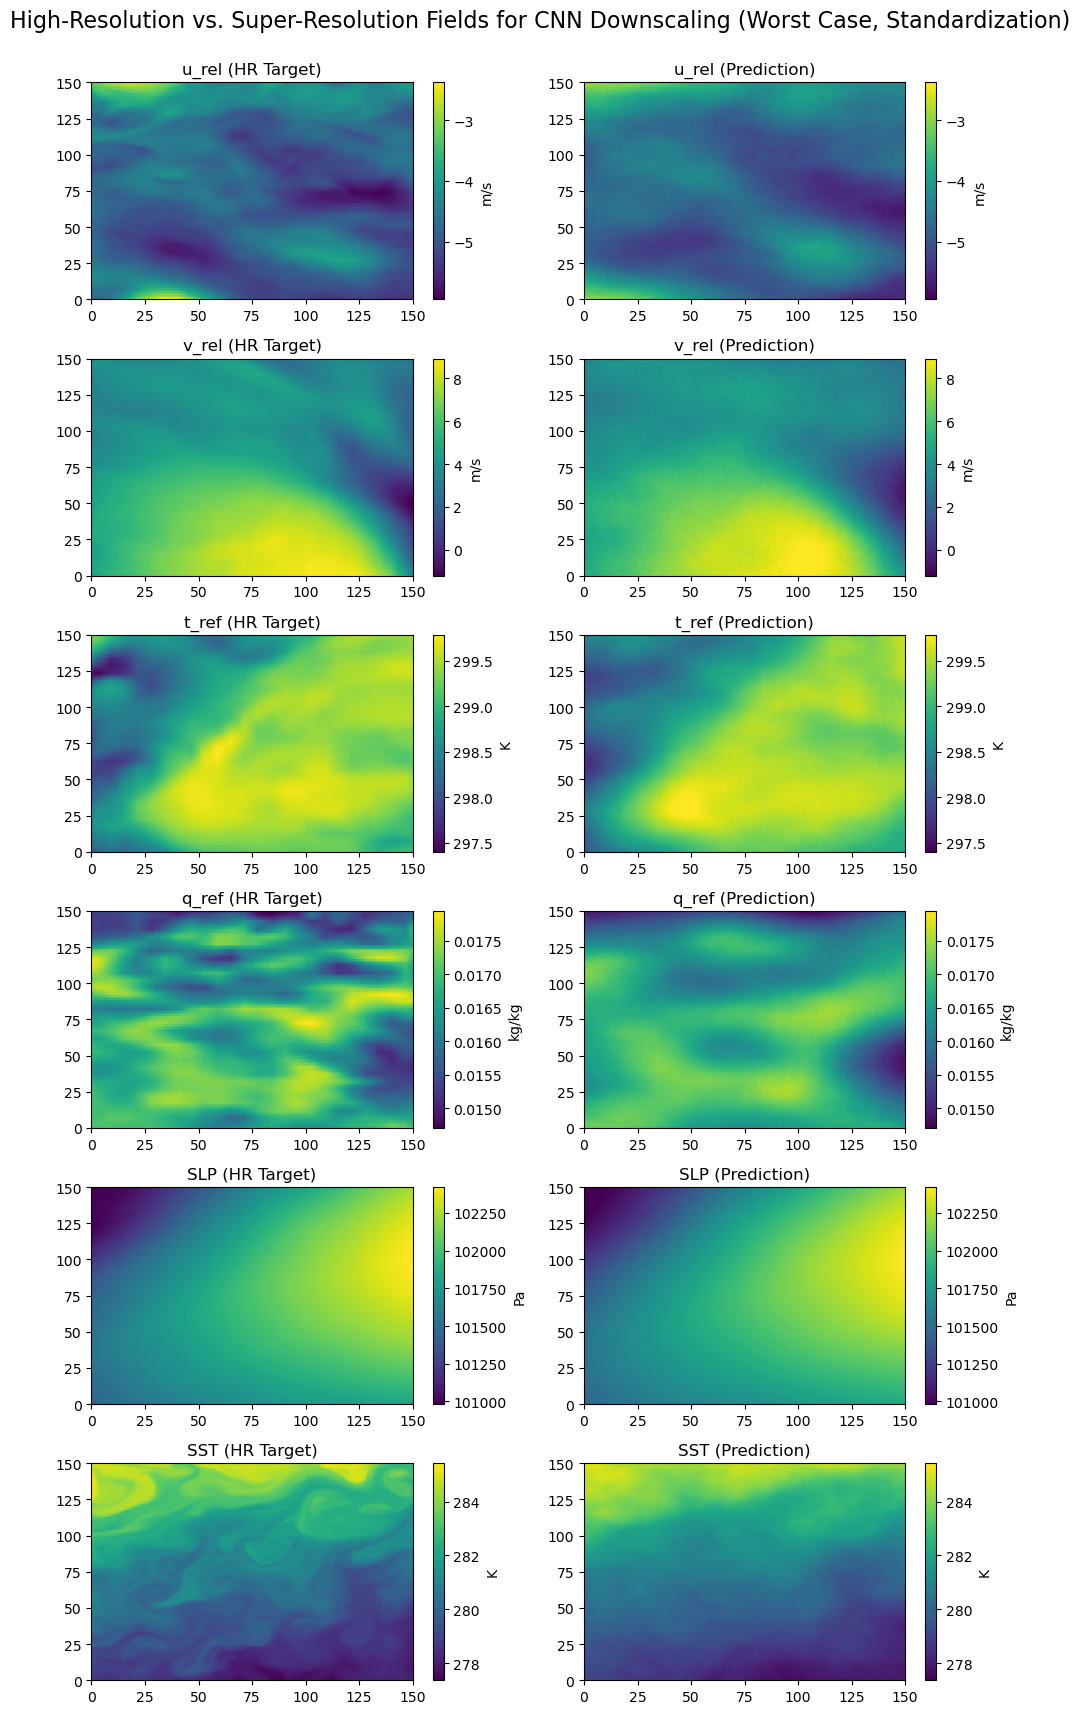

In [39]:
fig, axes = plt.subplots(6, 2, figsize=(10, 18))

vmins = [urel_HR_test[min_idx].min().values, vrel_HR_test[min_idx].min().values, tref_HR_test[min_idx].min().values,
         qref_HR_test[min_idx].min().values, slp_HR_test[min_idx].min().values, sst_HR_test[min_idx].min().values]
vmaxs = [urel_HR_test[min_idx].max().values, vrel_HR_test[min_idx].max().values, tref_HR_test[min_idx].max().values,
         qref_HR_test[min_idx].max().values, slp_HR_test[min_idx].max().values, sst_HR_test[min_idx].max().values]

# Add figure-level title
fig.suptitle("High-Resolution vs. Super-Resolution Fields for CNN Downscaling (Worst Case, Standardization)", fontsize=16, y=0.95)

# Top-left
im = axes[0, 0].pcolor(urel_HR_test[min_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 0].set_title("u_rel (HR Target)")
fig.colorbar(im, ax=axes[0, 0], label="m/s")

# Top-right
im = axes[0, 1].pcolor(urel_sr_pred[min_idx], vmin=vmins[0], vmax=vmaxs[0], shading='auto')
axes[0, 1].set_title("u_rel (Prediction)")
fig.colorbar(im, ax=axes[0, 1], label="m/s")

# Second row
im = axes[1, 0].pcolor(vrel_HR_test[min_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 0].set_title("v_rel (HR Target)")
fig.colorbar(im, ax=axes[1, 0], label="m/s")

im = axes[1, 1].pcolor(vrel_sr_pred[min_idx], vmin=vmins[1], vmax=vmaxs[1], shading='auto')
axes[1, 1].set_title("v_rel (Prediction)")
fig.colorbar(im, ax=axes[1, 1], label="m/s")

# Third row
im = axes[2, 0].pcolor(tref_HR_test[min_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 0].set_title("t_ref (HR Target)")
fig.colorbar(im, ax=axes[2, 0], label="K")

im = axes[2, 1].pcolor(tref_sr_pred[min_idx], vmin=vmins[2], vmax=vmaxs[2], shading='auto')
axes[2, 1].set_title("t_ref (Prediction)")
fig.colorbar(im, ax=axes[2, 1], label="K")

# Fourth row
im = axes[3, 0].pcolor(qref_HR_test[min_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 0].set_title("q_ref (HR Target)")
fig.colorbar(im, ax=axes[3, 0], label="kg/kg")

im = axes[3, 1].pcolor(qref_sr_pred[min_idx], vmin=vmins[3], vmax=vmaxs[3], shading='auto')
axes[3, 1].set_title("q_ref (Prediction)")
fig.colorbar(im, ax=axes[3, 1], label="kg/kg")

# Fifth row
im = axes[4, 0].pcolor(slp_HR_test[min_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 0].set_title("SLP (HR Target)")
fig.colorbar(im, ax=axes[4, 0], label="Pa")

im = axes[4, 1].pcolor(slp_sr_pred[min_idx], vmin=vmins[4], vmax=vmaxs[4], shading='auto')
axes[4, 1].set_title("SLP (Prediction)")
fig.colorbar(im, ax=axes[4, 1], label="Pa")

# Sixth row
im = axes[5, 0].pcolor(sst_HR_test[min_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 0].set_title("SST (HR Target)")
fig.colorbar(im, ax=axes[5, 0], label="K")

im = axes[5, 1].pcolor(sst_sr_pred[min_idx], vmin=vmins[5], vmax=vmaxs[5], shading='auto')
axes[5, 1].set_title("SST (Prediction)")
fig.colorbar(im, ax=axes[5, 1], label="K")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# SGS HF Contribution Plots

In [1]:
from xgcm import Grid
import pop_tools
import gcsfs
import fsspec as fs
import numpy as np
import xesmf as xe
import xarray as xr
import random
import matplotlib.pyplot as plt
import warnings
from xgcm import Grid
import importlib
# import preprocessing
import os
import xrft
import gcm_filters
import random
import scipy
from scipy.ndimage import convolve

warnings.filterwarnings("ignore")

from gcm_filtering import filter_inputs_dataset
from gcm_filtering import filter_inputs

import aerobulk
from aerobulk import noskin

In [2]:
def r2_per_sample(y_true, y_pred):
    n_samples = y_true.shape[0]
    r2_scores = np.empty(n_samples)
    
    for i in range(n_samples):
        yt = y_true[i].reshape(-1)
        yp = y_pred[i].reshape(-1)
        ss_res = np.sum((yt - yp) ** 2)
        ss_tot = np.sum((yt - np.mean(yt)) ** 2)
        r2_scores[i] = 1 - ss_res / ss_tot
    
    return r2_scores

In [3]:
def r2(y_true, y_pred):
    
    yt = y_true.reshape(-1)
    yp = y_pred.reshape(-1)
    ss_res = np.sum((yt - yp) ** 2)
    ss_tot = np.sum((yt - np.mean(yt)) ** 2)
    r2_scores = 1 - ss_res / ss_tot
    
    return r2_scores

## Import data

In [4]:
ds_all = xr.open_dataset(
"gs://leap-persistent/panalluri/cnn_stand_fluxInputs_global.zarr", engine="zarr", chunks={}
)
ds_all

<xarray.Dataset>
Dimensions:   (time: 1314, y: 150, x: 150)
Dimensions without coordinates: time, y, x
Data variables: (12/18)
    q_ref_hr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    q_ref_lr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    q_ref_sr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    slp_hr    (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    slp_lr    (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    slp_sr    (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    ...        ...
    u_rel_hr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    u_rel_lr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    u_rel_sr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    v_rel_hr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    v_rel_lr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>
    v_rel_sr  (time, y, x) float32 dask.array<chunksize=(165, 38, 38), meta=np.ndarray>

## Stats for all samples

In [5]:
ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_sr,
        ds_all.t_ref_sr,
        ds_all.q_ref_sr,
        ds_all.u_rel_sr,
        ds_all.v_rel_sr,
        slp=ds_all.slp_sr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_sr_all = qh + ql

ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_lr,
        ds_all.t_ref_lr,
        ds_all.q_ref_lr,
        ds_all.u_rel_lr,
        ds_all.v_rel_lr,
        slp=ds_all.slp_lr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_lr_all = qh + ql

ql, qh, taux, tauy, evap =  noskin(
        ds_all.sst_hr,
        ds_all.t_ref_hr,
        ds_all.q_ref_hr,
        ds_all.u_rel_hr,
        ds_all.v_rel_hr,
        slp=ds_all.slp_hr,
        algo='ecmwf',
        zt=2,
        zu=10,
)

heatflux_hr_all = qh + ql

In [6]:
# Make a Dataset
ds_heatflux = xr.Dataset()

# Manually add variables
ds_heatflux["heatflux_hr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_lr_all.values)
ds_heatflux["heatflux_lr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_hr_all.values)
ds_heatflux["heatflux_sr"] = (("time", "yt_ocean", "xt_ocean"), heatflux_sr_all.values)

ds_heatflux

<xarray.Dataset>
Dimensions:      (time: 1314, yt_ocean: 150, xt_ocean: 150)
Dimensions without coordinates: time, yt_ocean, xt_ocean
Data variables:
    heatflux_hr  (time, yt_ocean, xt_ocean) float64 31.37 31.18 ... -418.6
    heatflux_lr  (time, yt_ocean, xt_ocean) float64 34.62 34.47 ... -462.0
    heatflux_sr  (time, yt_ocean, xt_ocean) float64 36.34 35.64 ... -388.5

In [7]:
print("Filtering model")
heatflux_smooth = filter_inputs_dataset(ds_heatflux, ['yt_ocean', 'xt_ocean'], filter_scale=50, filter_type='gaussian')
heatflux_smooth

Filtering model


<xarray.Dataset>
Dimensions:      (time: 1314, yt_ocean: 150, xt_ocean: 150)
Dimensions without coordinates: time, yt_ocean, xt_ocean
Data variables:
    heatflux_hr  (time, yt_ocean, xt_ocean) float64 -13.89 -14.64 ... -150.4
    heatflux_lr  (time, yt_ocean, xt_ocean) float64 -13.51 -14.31 ... -158.8
    heatflux_sr  (time, yt_ocean, xt_ocean) float64 -14.41 -15.16 ... -157.4
Attributes:
    filter_scale:  50
    filter_type:   gaussian

In [8]:
HF_SGS_all_pred = heatflux_smooth.heatflux_sr - heatflux_smooth.heatflux_lr
HF_SGS_all_true = heatflux_smooth.heatflux_hr - heatflux_smooth.heatflux_lr

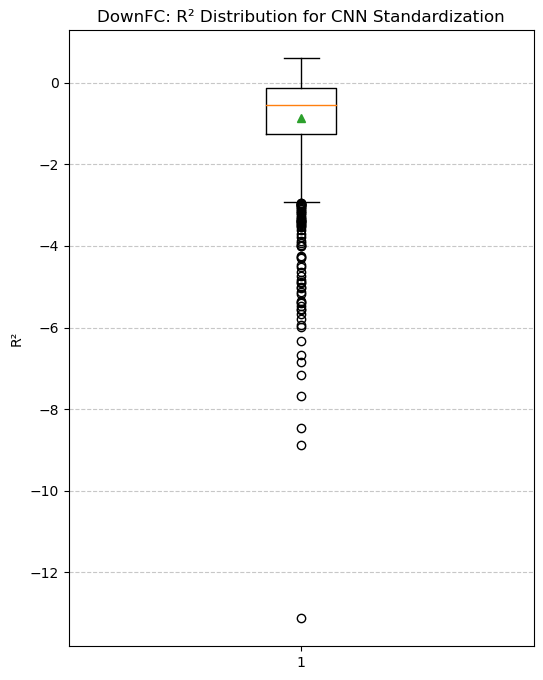

In [9]:
r2_all = r2_per_sample(HF_SGS_all_true.values, HF_SGS_all_pred.values)
plt.figure(figsize=(6, 8))
plt.boxplot(r2_all, vert=True, showmeans=True)
plt.ylabel("R²")
plt.title("DownFC: R² Distribution for CNN Standardization")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Best case results (from SGS HF R2 values)

In [10]:
arr = r2_all

max_val = arr.max()        # get the minimum value
max_idx = arr.argmax()     # get the index of the minimum value

print("Maximum R2 value:", max_val)
print("Index of maximum:", max_idx)

Maximum R2 value: 0.5953289356294629
Index of maximum: 91


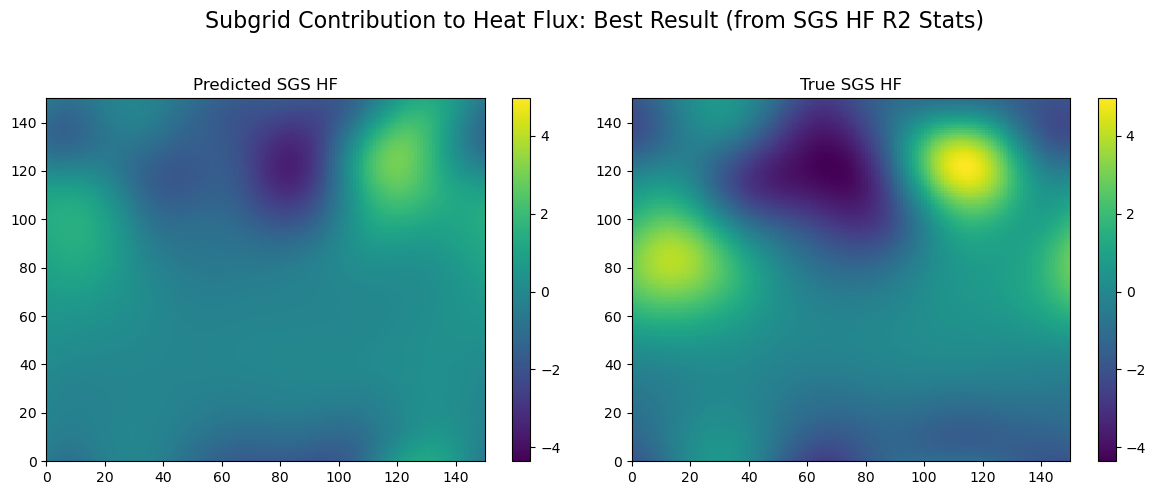

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=max_idx)
data2 = HF_SGS_all_true.isel(time=max_idx)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Best Result (from SGS HF R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

## Worst case results (from SGS HF R2 values)

In [ ]:
arr = r2_all

min_val = arr.min()        # get the minimum value
min_idx = arr.argmin()     # get the index of the minimum value

print("Minimum R2 value:", min_val)
print("Index of minimum:", min_idx)

Minimum R2 value: -13.122131447581452
Index of minimum: 1230


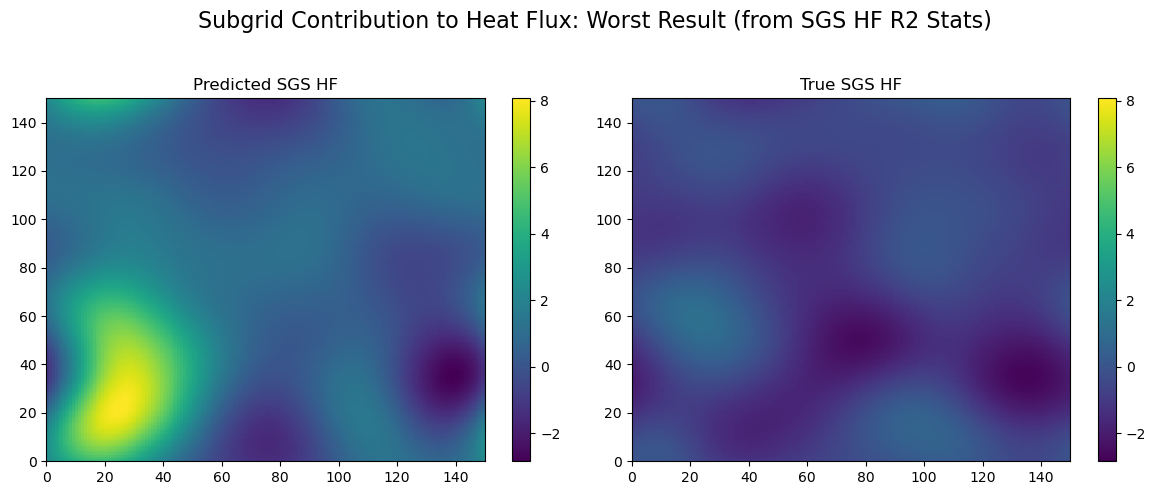

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=min_idx)
data2 = HF_SGS_all_true.isel(time=min_idx)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Worst Result (from SGS HF R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

## Best Case Results (from downscaling R2 values)

In [ ]:
max_idx_down = 102
min_idx_down = 59

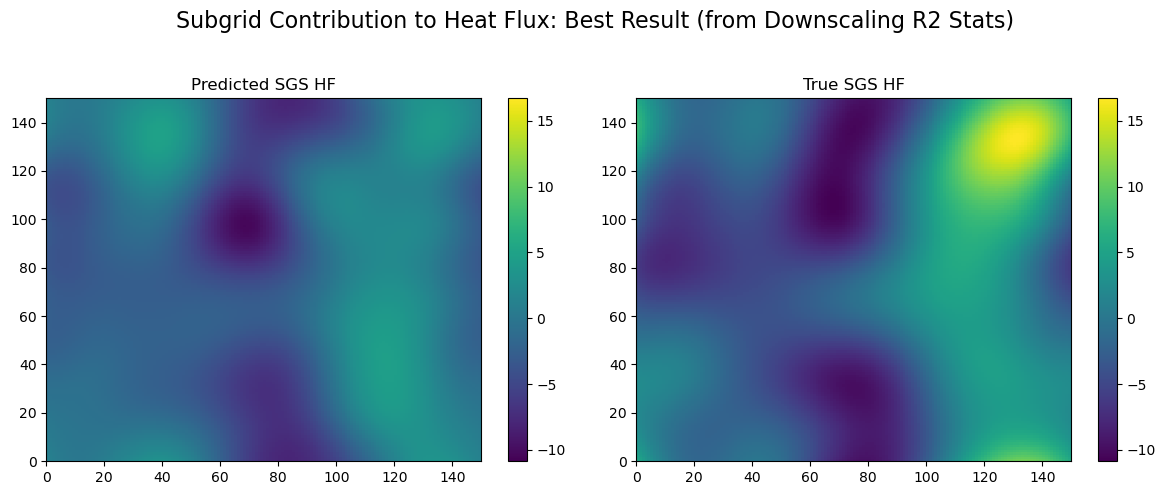

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=max_idx_down)
data2 = HF_SGS_all_true.isel(time=max_idx_down)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Best Result (from Downscaling R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

In [ ]:
data1 = HF_SGS_all_pred.isel(time=max_idx_down)
data2 = HF_SGS_all_true.isel(time=max_idx_down)
r2(data1.values, data2.values)

-0.38769793513802875

## Worst Case Results (from downscaling R2 values)

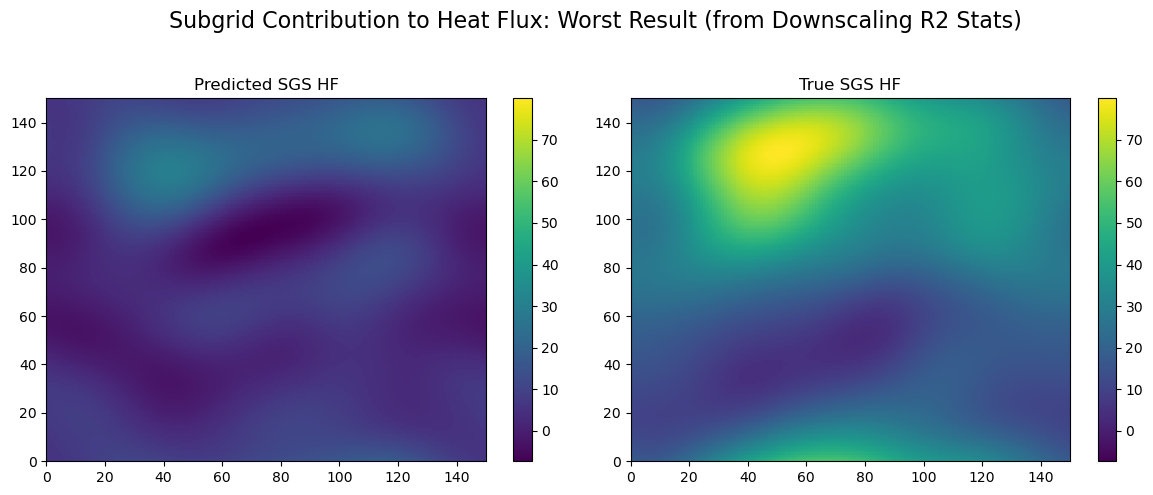

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

data1 = HF_SGS_all_pred.isel(time=min_idx_down)
data2 = HF_SGS_all_true.isel(time=min_idx_down)
vmin = min(data1.min(), data2.min()).item()
vmax = max(data1.max(), data2.max()).item()

# Plot predicted
im0 = axes[0].pcolor(data1, vmin=vmin, vmax=vmax)
axes[0].set_title('Predicted SGS HF')
fig.colorbar(im0, ax=axes[0])

# Plot true
im1 = axes[1].pcolor(data2, vmin=vmin, vmax=vmax)
axes[1].set_title('True SGS HF')
fig.colorbar(im1, ax=axes[1])

# Add supertitle
fig.suptitle('Subgrid Contribution to Heat Flux: Worst Result (from Downscaling R2 Stats)', fontsize=16)

plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for supertitle
plt.show()

In [ ]:
data1 = HF_SGS_all_pred.isel(time=min_idx_down)
data2 = HF_SGS_all_true.isel(time=min_idx_down)
r2(data1.values, data2.values)

-12.06071890591183